Traffic Sign Classification

In [1]:
#importing Libraries for data analysis
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
import pickle
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import cv2
import skimage.morphology as morp
from skimage.filters import rank

We will use Python pickle to load the data.

In [2]:
with open("./dataset/train.p", mode='rb') as d:
    train = pickle.load(d)
with open("./dataset/valid.p", mode='rb') as d:
    valid = pickle.load(d)
with open("./dataset/test.p", mode='rb') as d:
    test = pickle.load(d)

    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_testr, y_test = test['features'], test['labels']

n_train = x_train.shape[0]
n_validation = x_valid.shape[0]
n_test = x_testr.shape[0]
image_shape = x_train.shape[1:]
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
signdata = []
with open('signid.csv', 'r') as d:
    signid = csv.reader(d, delimiter=',')
    next(signid,None)
    for row in signid:
        signdata.append(row[1])
    


In [4]:
# Shuffle the dataset 
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train)


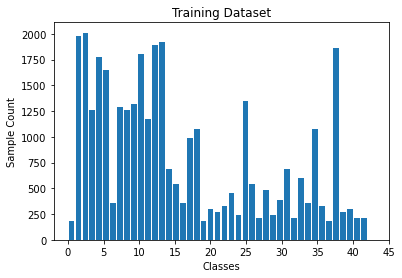

In [5]:
hist, bins = np.histogram(y_train, 43)
height = (bins[:-1] + bins[1:]) / 2
plt.bar(height, hist)
plt.title("Training Dataset")
plt.xticks([0,5,10,15,20,25,30,35,40,45])
plt.xlabel("Classes")
plt.ylabel("Sample Count")
plt.show()

In [6]:
def gray(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


def equalize(img):
    return cv2.equalizeHist(img)


def local_histo_equalize(img):
    kernel = morp.disk(30)
    return rank.equalize(img, selem=kernel)

def preprocess(img):
    img = gray(img)
    img =local_histo_equalize(img)
    img = equalize(img)
    #now normalizing the images
    img = img/255
    return img
  

In [7]:
x_train= np.array(list(map(preprocess,x_train)))
x_test = np.array(list(map(preprocess,x_testr)))
x_val = np.array(list(map(preprocess,x_valid)))

In [8]:
#reshaping the images

x_train = x_train.reshape(34799, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)

print(x_train.shape)

(34799, 32, 32, 1)


Model Training

In [9]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
cnn_model.add(AveragePooling2D())
cnn_model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
cnn_model.add(AveragePooling2D())
cnn_model.add(Flatten())
cnn_model.add(Dense(units=400, activation='relu'))
cnn_model.add(Dense(units=84, activation='relu'))
cnn_model.add(Dense(units=43, activation = 'softmax'))
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer='adam',metrics =['accuracy'])

In [10]:
history = cnn_model.fit(x_train,y_train,batch_size=400,epochs=15,verbose=1,validation_data = (x_val,y_valid))

Epoch 1/15
87/87 [==============================] - 15s 57ms/step - loss: 3.2956 - accuracy: 0.1478 - val_loss: 1.7602 - val_accuracy: 0.4891
Epoch 2/15
87/87 [==============================] - 4s 51ms/step - loss: 1.3371 - accuracy: 0.6007 - val_loss: 0.9299 - val_accuracy: 0.7336
Epoch 3/15
87/87 [==============================] - 5s 53ms/step - loss: 0.7601 - accuracy: 0.7792 - val_loss: 0.7238 - val_accuracy: 0.7692
Epoch 4/15
87/87 [==============================] - 5s 52ms/step - loss: 0.5625 - accuracy: 0.8370 - val_loss: 0.6069 - val_accuracy: 0.8168
Epoch 5/15
87/87 [==============================] - 4s 51ms/step - loss: 0.4334 - accuracy: 0.8769 - val_loss: 0.5484 - val_accuracy: 0.8370
Epoch 6/15
87/87 [==============================] - 5s 53ms/step - loss: 0.3594 - accuracy: 0.9006 - val_loss: 0.4655 - val_accuracy: 0.8660
Epoch 7/15
87/87 [==============================] - 5s 54ms/step - loss: 0.3002 - accuracy: 0.9197 - val_loss: 0.4574 - val_accuracy: 0.8621
Epoch 8/15
8

In [11]:
score = cnn_model.evaluate(x_test, y_test,verbose=0)
print('Test Accuracy : {:.4f}'.format(score[1]))


Test Accuracy : 0.8577


In [12]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

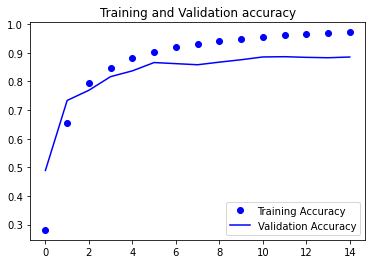

In [13]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

<AxesSubplot:>

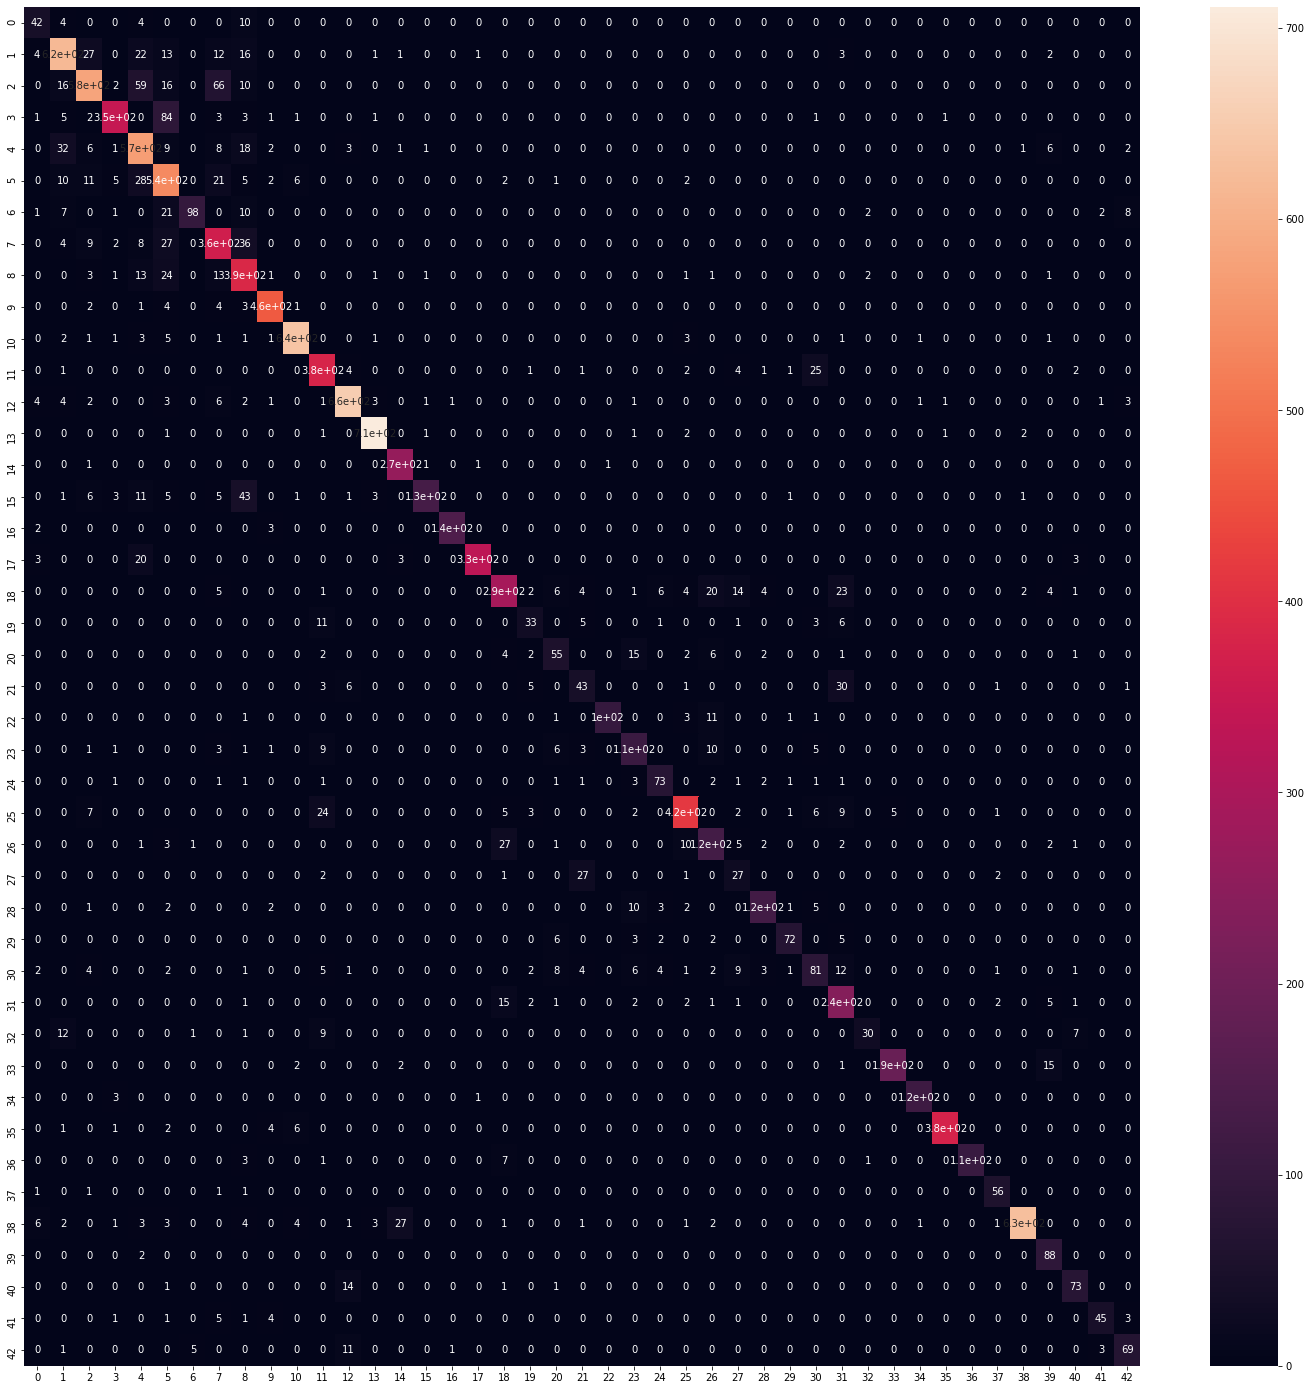

In [17]:
#get the predictions for the test data
predicted_classes = np.argmax(cnn_model.predict(x_test), axis=-1)
#get the indices to be plotted
y_true = y_test

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (25,25))
sns.heatmap(cm, annot=True)


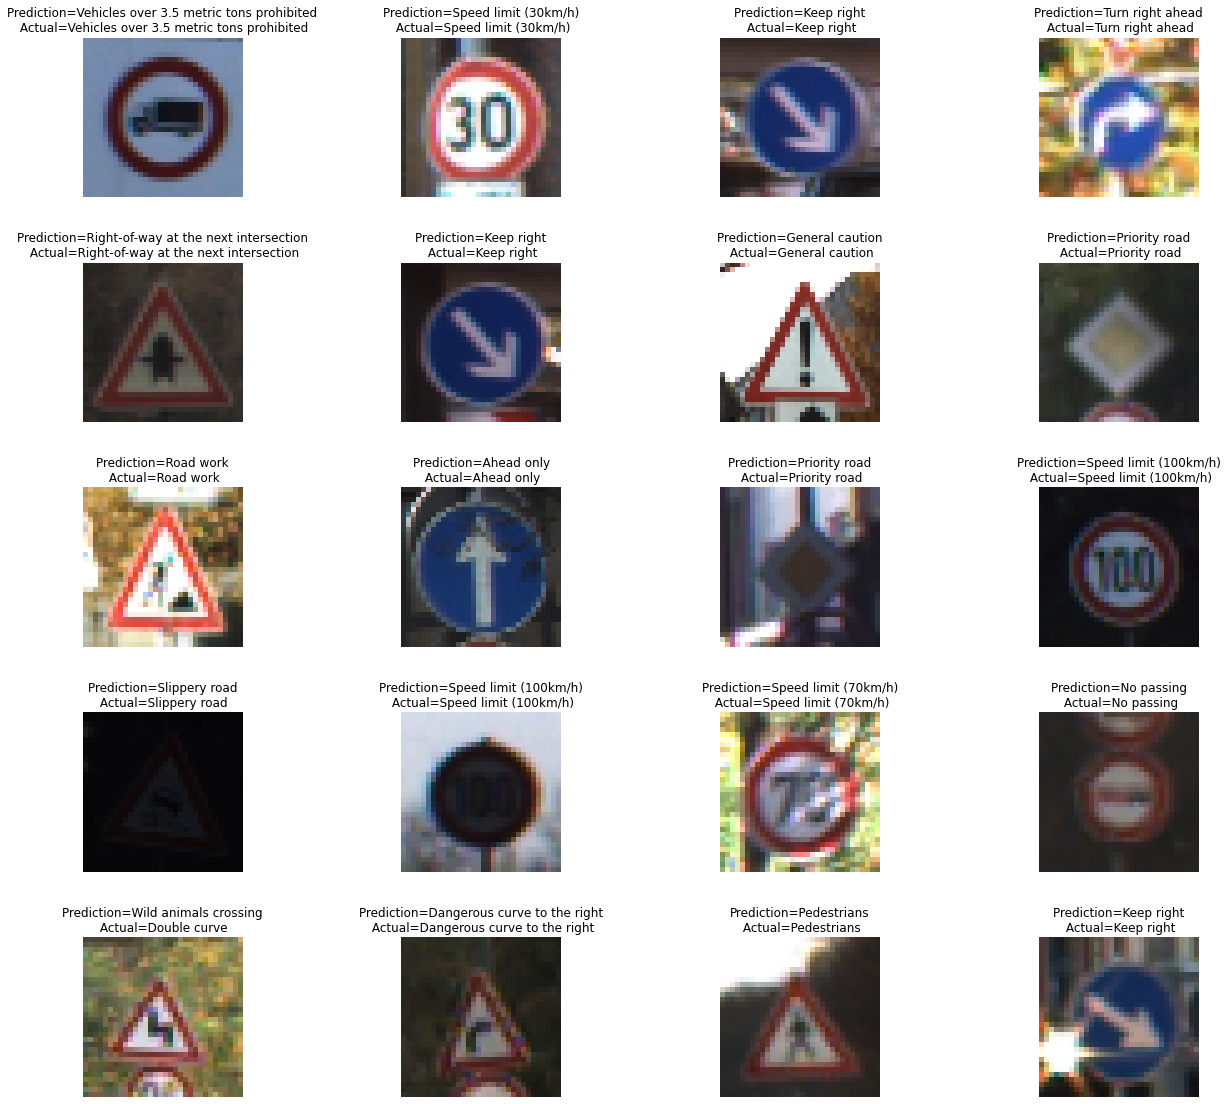

In [15]:
L = 5
W = 4
fig, axes = plt.subplots(L, W, figsize = (20,20))
axes = axes.ravel() # 

for i in np.arange(0, L * W):  
    axes[i].imshow(x_testr[i])
    axes[i].set_title("Prediction={}\n Actual={}".format(signdata[predicted_classes[i]], signdata[y_true[i]]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1)